In [8]:
import json
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from tqdm.auto import tqdm
sns.set_style("whitegrid")

In [32]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
!ls

README.md                       evaluation.py
__pycache__                     hello.py
data.json                       nb_experiments.ipynb
db                              pred.json
df_questions_all.csv            pyproject.toml
df_questions_not_impossible.csv uv.lock


In [12]:
filename = "data.json"
with open(filename, "rb") as f:
    dataset = json.load(f)

In [13]:
dataset.keys()

dict_keys(['version', 'data'])

In [14]:
dataset["version"]

'v2.0'

In [ ]:
len(dataset["data"])

35

In [16]:
data = dataset["data"]

In [ ]:
type(data)

list

In [ ]:
data[0]["paragraphs"][0]

{'qas': [{'question': 'In what country is Normandy located?',
   'id': '56ddde6b9a695914005b9628',
   'answers': [{'text': 'France', 'answer_start': 159},
    {'text': 'France', 'answer_start': 159},
    {'text': 'France', 'answer_start': 159},
    {'text': 'France', 'answer_start': 159}],
   'is_impossible': False},
  {'question': 'When were the Normans in Normandy?',
   'id': '56ddde6b9a695914005b9629',
   'answers': [{'text': '10th and 11th centuries', 'answer_start': 94},
    {'text': 'in the 10th and 11th centuries', 'answer_start': 87},
    {'text': '10th and 11th centuries', 'answer_start': 94},
    {'text': '10th and 11th centuries', 'answer_start': 94}],
   'is_impossible': False},
  {'question': 'From which countries did the Norse originate?',
   'id': '56ddde6b9a695914005b962a',
   'answers': [{'text': 'Denmark, Iceland and Norway', 'answer_start': 256},
    {'text': 'Denmark, Iceland and Norway', 'answer_start': 256},
    {'text': 'Denmark, Iceland and Norway', 'answer_star

#Json structure:
data = {"version": "x", 
         "data": [{"title": "...", 
                   "paragraphs": [
                       "qas": [{"question": "...", 
                                "id": "", 
                                "answers"}], # note in case of is_impossible = True, we have plausible answers?
                       "is_impossible": True, 
                       "context": "..."
                   ]}] 
   }

In [17]:
df_all_data = pd.DataFrame()

for list_idx, list_item in enumerate(data):
    title = list_item["title"]
    #print(title)
    
    paragraphs = list_item["paragraphs"]
    
    #print(paragraphs)
    
    for p_idx, paragraph in enumerate(paragraphs):
        paragraph_res = []
        
        context = paragraph["context"]

        for q_idx, qas in enumerate(paragraph["qas"]):
            question = qas["question"]
            is_impossible = qas["is_impossible"]
            answers = qas["answers"]
            question_id = qas["id"]
            
            # TODO: add plausible answers
            res = {"question": question, 
                   "list_idx": list_idx,
                   "paragraph_idx": p_idx,
                   "question_idx": q_idx,
                   "id": question_id, 
                   "is_impossible": is_impossible,
                   "answer_0": np.nan,
                   "answer_1": np.nan,
                   "answer_2": np.nan,
                   "answer_3": np.nan
            }
            
            if len(answers) > 0: 
                for idx, answer in enumerate(answers): 
                    #print(idx)
                    res[f"answer_{idx}"] = answer["text"]
                
            paragraph_res.append(res)

        paragraph_df = pd.DataFrame(paragraph_res)
        paragraph_df["context"] = context
        paragraph_df["title"] = title
        
        df_all_data = pd.concat([df_all_data, paragraph_df], ignore_index=True)
    

In [ ]:
df_all_data.head()

,question,list_idx,paragraph_idx,question_idx,id,is_impossible,answer_0,answer_1,answer_2,answer_3,context,title,answer_4,answer_5
0,In what country is Normandy located?,0,0,0,56ddde6b9a695914005b9628,False,France,France,France,France,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
1,When were the Normans in Normandy?,0,0,1,56ddde6b9a695914005b9629,False,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,10th and 11th centuries,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
2,From which countries did the Norse originate?,0,0,2,56ddde6b9a695914005b962a,False,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway",The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
3,Who was the Norse leader?,0,0,3,56ddde6b9a695914005b962b,False,Rollo,Rollo,Rollo,Rollo,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN
4,What century did the Normans first gain their ...,0,0,4,56ddde6b9a695914005b962c,False,10th century,the first half of the 10th century,10th,10th,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN


In [ ]:
df_all_data.shape

(11873, 14)

In [ ]:
len(df_all_data.title.unique())

35

In [ ]:
len(df_all_data.context.unique())

1204

In [ ]:
df_all_data.is_impossible.value_counts()

is_impossible
True     5945
False    5928
Name: count, dtype: int64

In [ ]:
# focus on the possible ones for now 

In [18]:
df_selected = df_all_data.copy()#df_all_data[~df_all_data.is_impossible].copy()

print(df_selected.shape)

(11873, 14)


In [19]:
# some rough statistics for the context length 
df_selected.loc[:, "context_chars"] = df_selected["context"].apply(lambda x: len(x))
df_selected.loc[:, "context_words"] = df_selected.loc[:, "context"].apply(lambda x: len(x.split(" ")))

In [20]:
df_selected.head()

,question,list_idx,paragraph_idx,question_idx,id,is_impossible,answer_0,answer_1,answer_2,answer_3,context,title,answer_4,answer_5,context_chars,context_words
0,In what country is Normandy located?,0,0,0,56ddde6b9a695914005b9628,False,France,France,France,France,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
1,When were the Normans in Normandy?,0,0,1,56ddde6b9a695914005b9629,False,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,10th and 11th centuries,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
2,From which countries did the Norse originate?,0,0,2,56ddde6b9a695914005b962a,False,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway",The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
3,Who was the Norse leader?,0,0,3,56ddde6b9a695914005b962b,False,Rollo,Rollo,Rollo,Rollo,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
4,What century did the Normans first gain their ...,0,0,4,56ddde6b9a695914005b962c,False,10th century,the first half of the 10th century,10th,10th,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113


<Axes: xlabel='context_chars', ylabel='Count'>

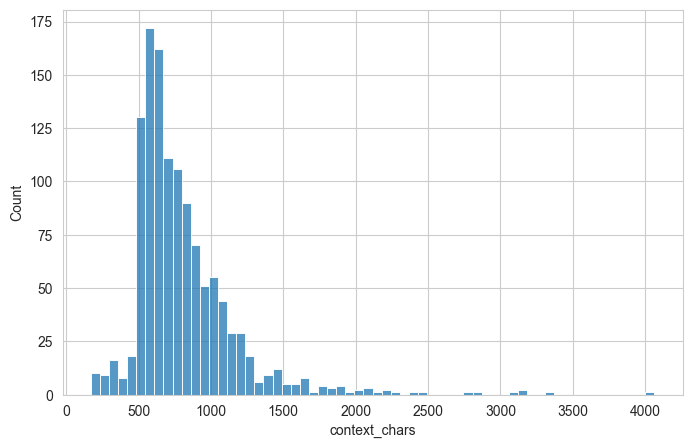

In [21]:
plt.figure(figsize=[8, 5])
sns.histplot(df_selected.drop_duplicates(subset="context")["context_chars"])

<Axes: xlabel='context_words', ylabel='Count'>

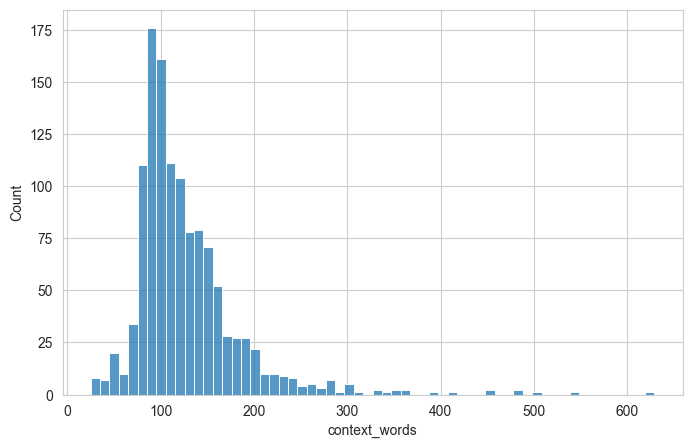

In [22]:
plt.figure(figsize=[8, 5])
sns.histplot(df_selected.drop_duplicates(subset="context")["context_words"])

In [ ]:
df_all_data.to_csv("df_questions_all.csv", index=False)

In [ ]:
df_selected.to_csv("df_questions_not_impossible.csv", index=False)

# Build the RAG architecture

Steps:

**Data Indexing**

Converting text data into a searchable database of vector embeddings, which represent the meaning of the text in a format that computers can easily understand.
- **Documents Chunking**: The collection of documents is split into smaller chunks of text. This allows for more precise and relevant pieces of information to be fed into the language model when needed, avoiding information overload.
- **Vector Embeddings**: The chunks of text are then transformed into vector embeddings. These embeddings encode the meaning of natural language text into numerical representations.
- **Vector Database**: Finally, the vector embeddings are stored in a vector database, making them easily searchable.

**Documents -> Text chunks -> Vector Embeddings -> Vector DB**

**Load -> Split -> Embed -> Store**

In [24]:
from typing import Optional, List, Tuple
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [25]:
langchain_docs = []

for i, row in df_selected.drop_duplicates(subset="context").iterrows():
    context = row.context
    title = row.title
    if i == 0:
        print(context)
        print(title)
    document = LangchainDocument(
        page_content=context,
        metadata={"title": title})

    langchain_docs.append(document)

The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Normans


In [ ]:
len(langchain_docs)

In [ ]:
langchain_docs[0]

In [ ]:
langchain_docs[1]

### Chunking

In [26]:
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    #tokenizer_name: str,
    ) -> List[LangchainDocument]:

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )
    
    docs_processed = []
    
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    """
    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)"""

    return docs_processed 

In [34]:
docs_processed = split_documents(200, langchain_docs)

In [ ]:
len(docs_processed)

In [ ]:
docs_processed[2]

### Embeddings & Vector DB

In [35]:
def create_vector_store(docs, embeddings, store_name, db_dir):
    persistent_directory = os.path.join(db_dir, store_name)
    
    if not os.path.exists(persistent_directory):
        print(f"\n--- Creating vector store {store_name} ---")
        Chroma.from_documents(
            docs, embeddings, persist_directory=persistent_directory)
        print(f"--- Finished creating vector store {store_name} ---")
    else:
        print(
            f"Vector store {store_name} already exists. No need to initialize.")

In [36]:
current_dir = !pwd

In [37]:
current_dir

['/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments_new']

In [38]:
db_dir = os.path.join(current_dir[0], "db")

In [39]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

In [40]:
openai_embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

#huggingface_embeddings = HuggingFaceEmbeddings(
 #   model_name="sentence-transformers/all-mpnet-base-v2"
#)
create_vector_store(docs_processed, openai_embeddings, "chroma_db_openai", db_dir)
#create_vector_store(docs_processed, huggingface_embeddings, "chroma_db_huggingface", db_dir)

Vector store chroma_db_openai already exists. No need to initialize.


In [41]:
def query_vector_store(store_name, query, embedding_function, db_dir):
    persistent_directory = os.path.join(db_dir, store_name)

    relevant_doct = []
    
    if os.path.exists(persistent_directory):
        db = Chroma(
            persist_directory=persistent_directory,
            embedding_function=embedding_function,
        )
        retriever = db.as_retriever(
            search_type="similarity_score_threshold",
            search_kwargs={"k": 3, "score_threshold": 0.1},
        )
        relevant_docs = retriever.invoke(query)
        
        # Display the relevant results with metadata
        #print(f"\n--- Relevant Documents for {store_name} ---")
        #for i, doc in enumerate(relevant_docs, 1):
         #   print(f"Document {i}:\n{doc.page_content}\n")

    else:
        print(f"Vector store {store_name} does not exist.")

    return relevant_docs

In [43]:
query = "How is the weather today in Milan"

# Query each vector store
relevant_docs = query_vector_store("chroma_db_openai", query, openai_embeddings, db_dir)
relevant_docs

[Document(metadata={'start_index': 363, 'title': 'Computational_complexity_theory'}, page_content='of the problem, such as asking for a round trip through all sites in Milan whose total length is at most 10 km'),
 Document(metadata={'start_index': 0, 'title': 'Jacksonville,_Florida'}, page_content='Mean monthly temperatures range from around 53 F in January to 82 F in July. High temperatures average 64 to 92 °F (18 to 33 °C) throughout the year'),
 Document(metadata={'start_index': 473, 'title': 'Jacksonville,_Florida'}, page_content='. Summers can be hot and wet, and summer thunderstorms with torrential but brief downpours are common.')]

In [ ]:
relevant_docs[0].page_content

# Use LLM with retrieved content 

In [ ]:
df_selected.shape

In [46]:
df_to_test = df_selected.copy()#df_selected[0:10]

In [47]:
#questions = ["How is the weather today in Milan"]

questions = df_to_test.question.tolist()
#questions

In [ ]:
filename = "data.json"
with open(filename, "rb") as f:
    dataset = json.load(f)

questions

In [ ]:
# check this for eval guidelines: 
# https://worksheets.codalab.org/worksheets/0x8212d84ca41c4150b555a075b19ccc05/
# https://rajpurkar.github.io/SQuAD-explorer/

In [44]:
from openai import OpenAI

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [48]:
answers = []
contexts = []

for question in tqdm(questions[0:100]):
    relevant_docs = query_vector_store("chroma_db_openai", query, openai_embeddings, db_dir)

    # TODO: review how to pass all documents
    context = relevant_docs[0].page_content
    
    # Create prompt with context
    prompt = f"""You are a helpful chatbot.
        Use only the following pieces of context to answer the question. Don't make up any new information:
        Context: {context}
        Answer:"""
    
    # Get response from OpenAI
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": question}
        ]
    )
    
    answer = response.choices[0].message.content
    
   # reference = context[0]  # Using first context as reference
   # the reference is the GT?

    answers.append(answer)
    contexts.append(context)

  3%|▎         | 3/100 [00:05<03:03,  1.89s/it]


KeyboardInterrupt: 

In [ ]:
df_to_test = df_to_test.loc[0:99]
df_to_test.loc[:, "answer_chatbot"] = answers
#df_to_test.loc[:, "correct_answer"] = df_to_test.apply(lambda x: x.answer_0 in x.answer_chatbot, axis=1)
df_to_test[["question", "answer_1", "answer_chatbot", "id"]].head()

In [ ]:
df_to_test.loc[3, "answer_chatbot"]

# Evaluation

In [ ]:
# save preds as json to run evaluation 

In [ ]:
preds = dict(zip(df_to_test["id"], df_to_test["answer_chatbot"]))
preds

In [ ]:
with open("pred.json", "w") as f:
    json.dump(preds, f)

# Create data.json only for a subset of questions

For testing and evaluation purposes on a smaller subset

In [ ]:
# TODO: check if the calculations make sense (check scores script)

In [ ]:
filename = "pred.json"
with open(filename, "rb") as f:
    preds = json.load(f)

qids = list(preds.keys())

In [ ]:
df = pd.read_csv("df_questions_all.csv")
df.head()

In [ ]:
print(len(df))
df_sel = df[df["id"].isin(qids)]
print(len(df_sel))

In [ ]:
all_res = {"version": "v2.0", "data": []}

all_res_list = []

for list_idx in set(df_sel.list_idx):
    print(list_idx)

    df_idx = df_sel[df_sel.list_idx == list_idx]

    title = df_idx.title[0]

    print("title", title)

    paragraphs = []
    
    list_res = {"title": title, 
                "paragraphs": paragraphs}
    
    paragraphs_idx = set(df_idx.paragraph_idx)
    
    print(paragraphs_idx)

    paragraphs_res = []

    for p_idx in paragraphs_idx:
        paragraph_df = df_idx[df_idx.paragraph_idx == p_idx]

        context = paragraph_df.context.iloc[0]

        paragraph_res = {"context": context, "qas": []}

        questions_df = paragraph_df[paragraph_df["id"].isin(qids)]

        if not questions_df.empty:
            question_idx = set(questions_df.question_idx)

            questions_list = []
        
            for q_idx in question_idx:
                question_df = questions_df[questions_df.question_idx == q_idx]

                question = question_df.question.iloc[0]
                question_id = question_df["id"].iloc[0]
                is_impossible = question_df.is_impossible.iloc[0]

                answers = []

                for i in range(0,3):
                    answer = question_df[f"answer_{i}"].iloc[0]

                    if answer == answer:
                    
                        answers.append({"text": answer})
                
                if is_impossible:
                    impossible_str = "true"
                else:
                    impossible_str = "false"
                
                question_res = {"question": question,  
                                "id": question_id,
                                "answers": answers,
                                "is_impossible": impossible_str
                               }
                
                questions_list.append(question_res)

            paragraph_res["qas"] = questions_list
                
        
        paragraphs.append(paragraph_res)

    all_res_list.append(list_res)
        
    

0
title Normans
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}


In [ ]:
with open("data_updated.json", "w") as f:
    json.dump(all_res, f)